# Sistema de Recomendação Baseado em Popularidade

Projeto criado com o conjunto de dados da Amazon, [Grocery and Gourmet Food](http://jmcauley.ucsd.edu/data/amazon/).


Neste projeto, nosso objetivo é criar um sistema de recomendação que nos dará os *n* produtos recomendados para um determinado usuário.

## SRBP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

In [2]:
df = pd.read_csv('Grocery_and_Gourmet_Food.csv', header=None, names = ['user_id','prod_id','rating', 'timestamp'])
df.head()

,user_id,prod_id,rating,timestamp
0,1888861614,ALP49FBWT4I7V,5.0,1370304000
1,1888861614,A1KPIZOCLB9FZ8,4.0,1400803200
2,1888861614,A2W0FA06IYAYQE,4.0,1399593600
3,1888861614,A2PTZTCH2QUYBC,5.0,1397952000
4,1888861614,A2VNHGJ59N4Z90,4.0,1397606400


In [3]:
df.drop('timestamp',axis=1, inplace=True)

### Análise Exploratória

In [4]:
df.shape

(5074160, 3)

In [5]:
df.describe(include='all')

,user_id,prod_id,rating
count,5074160,5074160,5.074160e+06
unique,283507,2695974,NaN
top,B00BUKL666,A1LACH6MLQWZ,NaN
freq,11526,1103,NaN
mean,NaN,NaN,4.314708e+00
std,NaN,NaN,1.249303e+00
min,NaN,NaN,1.000000e+00
25%,NaN,NaN,4.000000e+00
50%,NaN,NaN,5.000000e+00
75%,NaN,NaN,5.000000e+00


Observações:
* O ID de usuário que aparece mais vezes é o B00BUKL666 - 11526 vezes
* O produto A1LACH6MLQWZ é o que possui mais avaliações - 1103 vezes

In [6]:
df.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


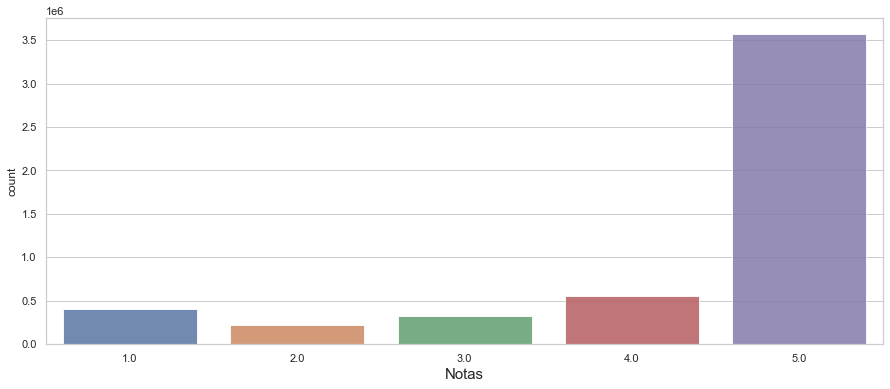

In [29]:
# Histograma
plt.figure(figsize=(15,6))
sns.countplot('rating', data=df, alpha=0.85)
plt.xlabel('Notas', size=15)
plt.show()

In [7]:
print(f'Número total de notas: {len(df)} \nNúmero total de usuários: {len(df.user_id.unique())} \
\nNúmero médio de avaliações por usuário: {round(len(df)/len(df.user_id.unique()),2)}')

Número total de notas: 5074160 
Número total de usuários: 283507 
Número médio de avaliações por usuário: 17.9


### Visualização

In [8]:
more = df.groupby('user_id').rating.count().sort_values(ascending=False)

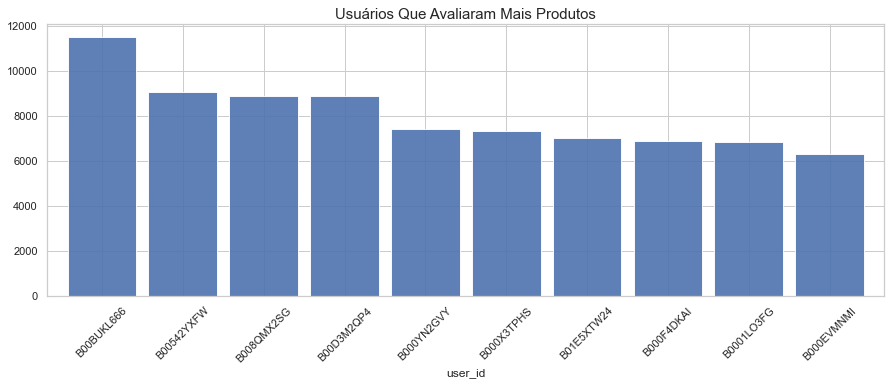

In [9]:
plt.figure(figsize=(15,5))
more.head(10).plot(kind='bar', alpha=0.9, width=0.85)
plt.title("Usuários Que Avaliaram Mais Produtos", size=15)
plt.xticks(rotation=45)
plt.show()

In [10]:
print(f'Número de usuários que avaliaram 50 ou mais produtos: {sum(more>=50)}')
print(f'Número de usuários que avaliaram mais de 50 produtos: {sum(more>50)}')

Número de usuários que avaliaram 50 ou mais produtos: 17393
Número de usuários que avaliaram mais de 50 produtos: 17017


In [11]:
df['rating'].count()

5074160

In [12]:
# Dataframe com produtos que possuem mais de 50 avaliações
new_df=df.groupby("prod_id").filter(lambda x:x['rating'].count() >=50)

In [13]:
new_df.head()

,user_id,prod_id,rating
115,4639725043,ALOGZDSPWZI72,4.0
128,4639725043,A1WOMXOEX90ARI,5.0
138,4639725043,AADZHUJW0KSDC,4.0
396,9742356831,A1BJVYTBOS2AGM,5.0
450,9742356831,ANTWFVZZKSBSF,5.0


In [14]:
# Novo DataFrame com média de avaliação e números de avaliações por produto
ratings_df = pd.DataFrame(new_df.groupby('prod_id').rating.mean())

In [15]:
# Avaliações por produto
ratings_df['rating_counts'] = new_df.groupby('prod_id').rating.count()

In [16]:
# Visualizando os 5 produtos com melhor avaliação
ratings_df.sort_values(by='rating_counts', ascending=False).head(5)

,rating,rating_counts
prod_id,,
A1LACH6MLQWZ,4.914778,1103
A1GQAKL9CGQLP1,4.508696,690
A2GJX2KCUSR0EI,4.341837,588
A2C9XE9I8RSKNX,4.264000,500
A2Q7DE6NA7VKAJ,3.906694,493


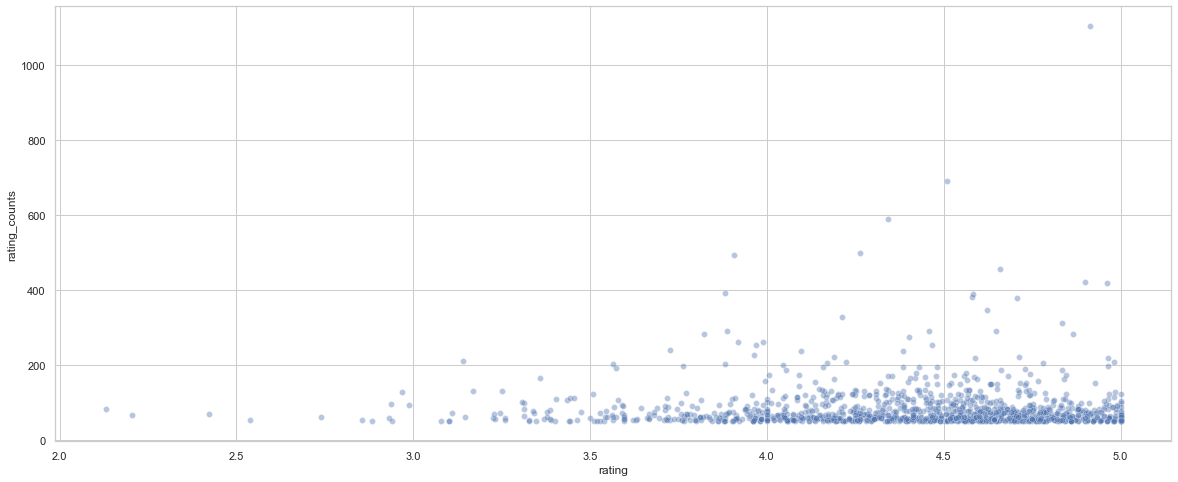

In [26]:
plt.figure(figsize=(20,8))
sns.scatterplot(x='rating', y='rating_counts', data=ratings_df, alpha=0.4)
plt.show()

Aqui podemos perceber que a maior parte dass avaliações estão entre 3-5.

Agora o que vamos fazer é calcular a média global. Já temos os votos mínimos necessários para ser elegível para o recomendador, ou seja, 50 votos.

Em seguida, definiremos uma função para calcular uma média ponderada que pega o número total de votos e o limite (50) e o multiplica pela média global e pela média do produto. A fórmula é:
(v/(v+m) * R) + (m/(m+v) * C)

- v é o número de votos para o produto;
- m são os votos mínimos necessários para serem listados no gráfico;
- R é a avaliação média do produto;
- C é a média das avaliações.

In [30]:
# A média global das avaliações
C = ratings_df['rating'].mean()
print(round(C,2))

4.38


In [31]:
# Usa o número mínimo de votos necessários para estar no recomendador
m = ratings_df.rating_counts.min(); m

50

In [32]:
# Função que calcula a avaliação ponderada de cada filme
def weighted_rating(x, m=m, C=C):
    v = x['rating_counts']
    R = x['rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [34]:
# Adiciona a 'pontuação' calculada com weighted_rating() ao dataframe
ratings_df['score'] = ratings_df.apply(weighted_rating, axis=1)

In [35]:
# Resultado final com os 15 produtos mais populares
ratings_df.sort_values(by='score', ascending=False).head(15)

,rating,rating_counts,score
prod_id,,,
A2PF64RBR1G1SZ,4.961722,418,4.899794
A1LACH6MLQWZ,4.914778,1103,4.891677
A3JXARXF2KGBIS,4.980769,208,4.864742
A8CGWGJ9OM58J,4.963636,220,4.855938
A2SQJPUCZNHMZE,4.964646,198,4.847191
A2NYK9KWFMJV4Y,4.900238,421,4.845230
AUA29FELQ9CB6,5.000000,122,4.820369
A1LZJZIHUPLDV4,4.984496,129,4.816220
A2KMO0N4GW8PX6,4.982759,116,4.801828
